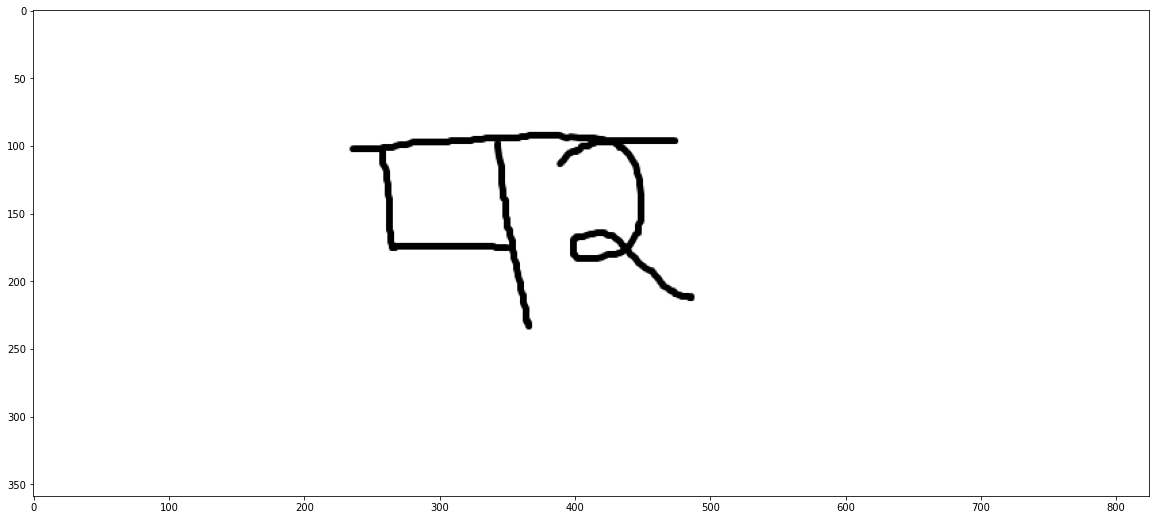

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import warnings
warnings.filterwarnings("ignore")

img = cv2.imread("par.png", 0)

def show(img, figsize=(20, 20)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray")
    plt.show()
show(img)

# Crop an Image

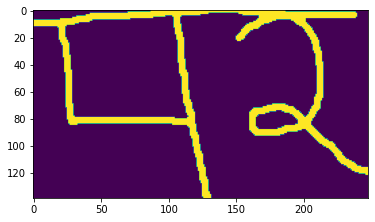

In [2]:
def borders(here_img, thresh, bthresh=0.092):
    shape = here_img.shape
    #check = int(115 * size[0] / 600)
    #check = int(55 * size[0] / 600)
    check= int(bthresh*shape[0])
    image = here_img[:]
    top, bottom = 0, shape[0] - 1
    #plt.imshow(image)
    #plt.show()
    

    #find the background color for empty column
    bg = np.repeat(thresh, shape[1])
    count = 0
    for row in range(1, shape[0]):
        if  (np.equal(bg, image[row]).any()) == True:
            #print(count)
            count += 1
        else:
            count = 0
        if count >= check:
            top = row - check
            break
    

    bg = np.repeat(thresh, shape[1])
    count = 0
    rows = np.arange(1, shape[0])
    #print(rows)
    for row in rows[::-1]:
        if  (np.equal(bg, image[row]).any()) == True:
            count += 1
        else:
            count = 0
        if count >= check:
            bottom = row + count
            break

    d1 = (top - 2) >= 0 
    d2 = (bottom + 2) < shape[0]
    d = d1 and d2
    if(d):
        b = 2
    else:
        b = 0
    
    return (top, bottom, b)


def preprocess(bgr_img):#gray image   
    blur = cv2.GaussianBlur(bgr_img,(5,5),0)
    ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0
    
    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]
    
    plt.imshow(template)
    plt.show()
    return (template, tb, lr)
prepimg, tb, lr = preprocess(img)

# Segmentation

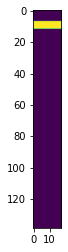

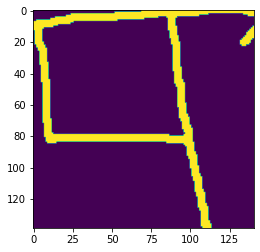

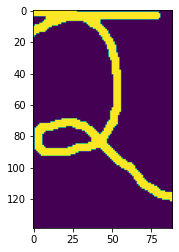

In [3]:
def segmentation(bordered, thresh=255, min_seg=10, scheck=0.15):
    try:
        shape = bordered.shape
        check = int(scheck * shape[0])
        image = bordered[:]
        image = image[check:].T
        shape = image.shape
        #plt.imshow(image)
        #plt.show()

        #find the background color for empty column
        bg = np.repeat(255 - thresh, shape[1])
        bg_keys = []
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).all()):
                bg_keys.append(row)            

        lenkeys = len(bg_keys)-1
        new_keys = [bg_keys[1], bg_keys[-1]]
        #print(lenkeys)
        for i in range(1, lenkeys):
            if (bg_keys[i+1] - bg_keys[i]) > check:
                new_keys.append(bg_keys[i])
                #print(i)

        new_keys = sorted(new_keys)
        #print(new_keys)
        segmented_templates = []
        first = 0
        bounding_boxes = []
        for key in new_keys[1:]:
            segment = bordered.T[first:key]
            if segment.shape[0]>=min_seg and segment.shape[1]>=min_seg:
                segmented_templates.append(segment.T)
                bounding_boxes.append((first, key))
            first = key
        
        last_segment = bordered.T[new_keys[-1]:]
        if last_segment.shape[0]>=min_seg and last_segment.shape[1]>=min_seg:
            segmented_templates.append(last_segment.T)
            bounding_boxes.append((new_keys[-1], new_keys[-1]+last_segment.shape[0]))


        return(segmented_templates, bounding_boxes)
    except:
        return [bordered, (0, bordered.shape[1])]
segments=segmentation(prepimg)
for simg in segments[0]:
    plt.imshow(simg)
    plt.show()

# Localize Text

[(84, 241, 233, 251), (84, 241, 251, 392), (84, 241, 392, 481)]


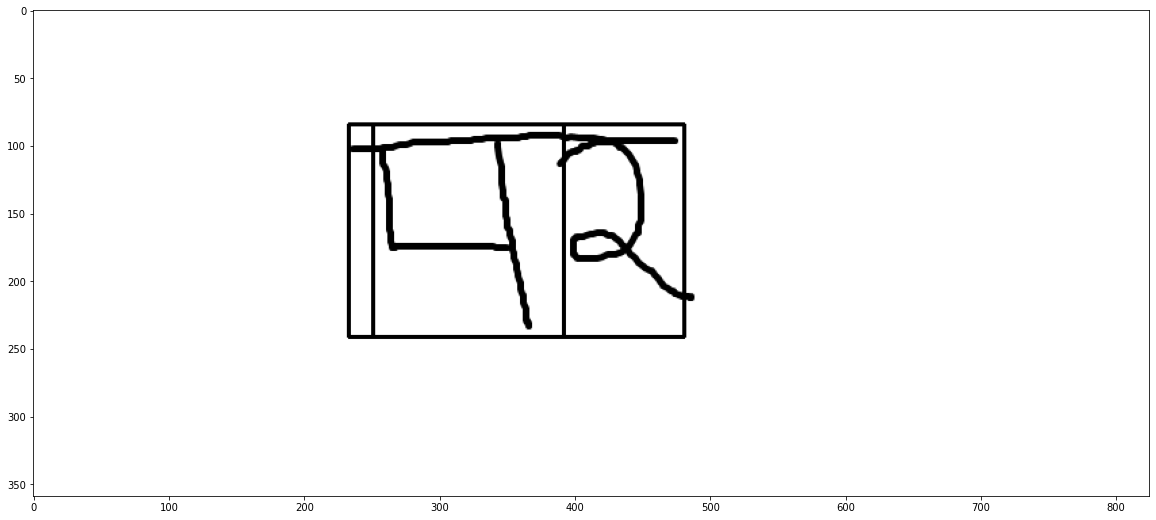

In [5]:
def localize(orig_img, tb, lr, segments):
    d=5
    rimg = orig_img.copy()
    boxes = []
    for simg, bb in zip(segments[0], segments[1]):
        bb = np.array(bb)
        bb += lr[0]
        # draw rows
        rimg[tb[0]-d:tb[0], bb[0]-d:bb[1]+d] = 0
        rimg[tb[1]:tb[1]+d, bb[0]-d:bb[1]+d] = 0

        # draw cols
        rimg[tb[0]-d:tb[1]+d, bb[0]-d:bb[0]+d] = 0
        rimg[tb[0]-d:tb[1]+d, bb[1]-d:bb[1]+d] = 0
        
        boxes.append((tb[0]-d, tb[1]+d, bb[0], bb[1]))
        #show(rimg)
    rimg = img.copy()
    print(boxes)
    for box in boxes:
        t, b, l, r = box
        cv2.rectangle(rimg, (l, t), (r, b), (0, 0, 0), 2)
    show(rimg)    
    return rimg, boxes
localized = localize(img, tb, lr, segments)

# Classification

In [6]:
import numpy as np
from tensorflow import keras
from keras.models import model_from_json
from keras.models import load_model

def prediction(img):
    # load json and create model
    json_file = open('part1 model\dcr.json', 'r')
    
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights("part1 model\dcr.h5")
    #print("Loaded model from disk")
    
    loaded_model.save('dcr.hdf5')
    loaded_model=load_model('dcr.hdf5')
    
    characters = '०,१,२,३,४,५,६,७,८,९,क,ख,ग,घ,ङ,च,छ,ज,झ,ञ,ट,ठ,ड,ढ,ण,त,थ,द,ध,न,प,फ,ब,भ,म,य,र,ल,व,श,ष,स,ह,क्ष,त्र,ज्ञ'
    characters = characters.split(',')
    
    x = np.asarray(img, dtype = np.float32).reshape(1, 32, 32, 1) / 255 
    
    output = loaded_model.predict(x)
    output = output.reshape(46)
    predicted = np.argmax(output)
    devanagari_label = characters[predicted]
    success = output[predicted] * 100
    
    return devanagari_label, success


In [7]:
def classifier(segments):
    pred_lbl = ""
    acc = []
    for segment in segments:
        segment = cv2.resize(segment, (32, 32))
        segment = cv2.GaussianBlur(segment, (3, 3), 0)
        segment = cv2.erode(segment, (3, 3), 1)
        #show(segment)
        
        lbl, a = prediction(segment)
        pred_lbl+=lbl
        acc.append(a)
    return pred_lbl, np.array(acc).mean()
classifier(segments[0])

1/1 [==============================] - 1s 633ms/step


('त्रडग', 48.10115247964859)

# Class: Devanagari Handwritten Character OCR

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from tensorflow import keras

from keras.models import model_from_json
from keras.models import load_model
from PIL import ImageDraw, Image, ImageFont


class DHCOCR:
    def __init__(self, model_dir="cnn/", bthresh=0.092, min_seg=10, scheck=0.15):
        self.model_dir = model_dir
        self.bthresh = bthresh
        self.check_color=5
        self.min_seg=min_seg
        self.scheck=scheck
        #self.thresh=thresh
        self.model = None
        self.fontPath="gargi.ttf"
        self.segment_prediction={}
        
    def show(self, img, figsize=(20, 20)):
        fig = plt.figure(figsize=figsize)
        plt.imshow(img, cmap="gray")
        plt.show()
          
    def borders(self, here_img, thresh):
        shape = here_img.shape
        check= int(self.bthresh*shape[0])
        image = here_img[:]
        top, bottom = 0, shape[0] - 1
    

        #find the background color for empty column
        bg = np.repeat(thresh, shape[1])
        count = 0
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).any()) == True:
                #print(count)
                count += 1
            else:
                count = 0
            if count >= check:
                top = row - check
                break


        bg = np.repeat(thresh, shape[1])
        count = 0
        rows = np.arange(1, shape[0])
        #print(rows)
        for row in rows[::-1]:
            if  (np.equal(bg, image[row]).any()) == True:
                count += 1
            else:
                count = 0
            if count >= check:
                bottom = row + count
                break

        d1 = (top - 2) >= 0 
        d2 = (bottom + 2) < shape[0]
        d = d1 and d2
        if(d):
            b = 2
        else:
            b = 0

        return (top, bottom, b)

    def preprocess(self, img):
        bgr_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(bgr_img,(5,5),0)
        ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

        rows, cols = th_img.shape
        bg_test = np.array([th_img[i][i] for i in range(5)])
        if bg_test.all() == 0:
            text_color = 255
        else:
            text_color = 0
        self.bg_color=text_color
        tb = self.borders(th_img, text_color)
        lr = self.borders(th_img.T, text_color)
        dummy = int(np.average((tb[2], lr[2]))) + 2
        template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]

        #plt.imshow(template)
        #plt.show()
        return (template, tb, lr)
    
    def segmentation(self, bordered):
        try:
            min_seg=self.min_seg
            scheck=self.scheck
            thresh=self.bg_color
            
            shape = bordered.shape
            check = int(scheck * shape[0])
            image = bordered[:]
            image = image[check:].T
            shape = image.shape
            #plt.imshow(image)
            #plt.show()

            #find the background color for empty column
            bg = np.repeat(255 - thresh, shape[1])
            bg_keys = []
            for row in range(1, shape[0]):
                if  (np.equal(bg, image[row]).all()):
                    bg_keys.append(row)            

            lenkeys = len(bg_keys)-1
            new_keys = [bg_keys[1], bg_keys[-1]]
            #print(lenkeys)
            for i in range(1, lenkeys):
                if (bg_keys[i+1] - bg_keys[i]) > check:
                    new_keys.append(bg_keys[i])
                    #print(i)

            new_keys = sorted(new_keys)
            #print(new_keys)
            segmented_templates = []
            first = 0
            bounding_boxes = []
            for key in new_keys[1:]:
                segment = bordered.T[first:key]
                if segment.shape[0]>=min_seg and segment.shape[1]>=min_seg:
                    segmented_templates.append(segment.T)
                    bounding_boxes.append((first, key))
                first = key

            last_segment = bordered.T[new_keys[-1]:]
            if last_segment.shape[0]>=min_seg and last_segment.shape[1]>=min_seg:
                segmented_templates.append(last_segment.T)
                bounding_boxes.append((new_keys[-1], new_keys[-1]+last_segment.shape[0]))

            #print(bounding_boxes)
            return(segmented_templates, bounding_boxes)
        except:
            return [[bordered], [(0, bordered.shape[1]-1)]]
    
    def localize(self, orig_img, tb, lr, segments):
        d=5
        rimg = orig_img.copy()
        boxes = []
        for simg, bb in zip(segments[0], segments[1]):
            bb = np.array(bb)
            bb += lr[0]
            # draw rows
            #rimg[tb[0]-d:tb[0], bb[0]-d:bb[1]+d] = 0
            #rimg[tb[1]:tb[1]+d, bb[0]-d:bb[1]+d] = 0

            # draw cols
            #rimg[tb[0]-d:tb[1]+d, bb[0]-d:bb[0]+d] = 0
            #rimg[tb[0]-d:tb[1]+d, bb[1]-d:bb[1]+d] = 0
            #print(tb, bb)
            boxes.append((tb[0]-d, tb[1]+d, bb[0], bb[1]))
            #show(rimg)
        rimg = self.img.copy()
        for box in boxes:
            t, b, l, r = box
            cv2.rectangle(rimg, (l, t), (r, b), (255-self.bg_color, 255-self.bg_color, 255-self.bg_color), d)
        #show(rimg)    
        self.boxes=boxes
        return rimg, boxes

    def prediction(self, img):
        # load json and create model
        if self.model is None:
            json_file = open('cnn\cnn.json', 'r')

            loaded_model_json = json_file.read()
            json_file.close()
            loaded_model = model_from_json(loaded_model_json)

            # load weights into new model
            loaded_model.load_weights("cnn\cnn.h5")
            #print("Loaded model from disk")

            loaded_model.save('cnn.hdf5')
            loaded_model=load_model('cnn.hdf5')
            self.model = loaded_model
            characters = '०,१,२,३,४,५,६,७,८,९,क,ख,ग,घ,ङ,च,छ,ज,झ,ञ,ट,ठ,ड,ढ,ण,त,थ,द,ध,न,प,फ,ब,भ,म,य,र,ल,व,श,ष,स,ह,क्ष,त्र,ज्ञ'
            self.characters = characters.split(',')

        else:
            loaded_model=self.model
            #characters = self.characters
        
        x = np.asarray(img, dtype = np.float32).reshape(1, 32, 32, 1) / 255 

        output = loaded_model.predict(x)
        output = output.reshape(46)
        predicted = np.argmax(output)
        devanagari_label = self.characters[predicted]
        success = output[predicted] * 100

        return devanagari_label, success
    
    def write_character(self, img, pos, txt, fsize=5, fcolor=(0, 100, 100, 0)):
        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(self.fontPath, fsize)
        draw.text(xy=pos, text=txt, font=font, fill=fcolor)
        
        return np.array(img)
        
    def classifier(self, segments):
        pred_lbl = ""
        acc = []
        
        #print(len(segments))
        for i, segment in enumerate(segments[0]):
            if self.bg_color==0:
                segment=255-segment
                #self.show(segment)
            segment = cv2.resize(segment, (32, 32))
            segment = cv2.GaussianBlur(segment, (3, 3), 0)
            segment = cv2.erode(segment, (3, 3), 1)
            #show(segment)
            lbl, a = self.prediction(segment)
            self.segment_prediction[self.boxes[i]] = lbl
            
            pred_lbl+=lbl
            acc.append(a)
        return pred_lbl, np.array(acc).mean()

    def easy_flow(self, img, view="image"):
        prepimg, tb, lr = self.preprocess(img)
        segments=self.segmentation(prepimg)
        #print(segments[1])
        localized = self.localize(img, tb, lr, segments)
        op = self.classifier(segments)
        
        print(op)
        if view=="image":
            d = int(100*500/localized[0].shape[0])
            limg = self.write_character(localized[0], pos=(lr[1], tb[0]-d), txt=op[0], fsize=d)            
            self.show(img=limg)
        elif view=="frame":
            d = int(30*400/localized[0].shape[0])
            #print(d)
            limg = self.write_character(localized[0], pos=(lr[0], tb[0]-d), txt=op[0], fsize=d)
            self.show(img=limg)
            #print(limg.shape)
            cv2.imshow("Detection", limg)
        
    def camera(self, flag):
        choice = print("Click spacebar for photo and anything else for video.\n")
        orig = 1
        cap = cv2.VideoCapture(0)
        tr = 0.1
        br = 0.8
        lc = 0.1
        rc = 0.8
        f = 0

        while(flag):    
            ret, frame = cap.read()
            if ret:
                self.img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                #frame = cv2.flip(frame, 1)
                #key event
                s = cv2.waitKey(2) & 0xFF

                if(chr(s) == 'x'):
                    f = -1
                if(chr(s) == 'z'):
                    f = 1

                if(chr(s) == 'a'):
                    tr = tr + 0.1 * f
                if(chr(s) == 'd'):
                    br = br + 0.1 * f
                if (chr(s) == 's'):
                    lc = lc + 0.1 * f
                if (chr(s) == 'w'):
                    rc = rc + 0.1 * f


                s_x, s_y = np.shape(frame)[0] * tr, np.shape(frame)[1] * lc
                e_x, e_y = np.shape(frame)[1] * br, np.shape(frame)[0] * rc
                s_x, s_y = np.int32(s_x), np.int32(s_y)
                e_x, e_y = np.int32(e_x), np.int32(e_y)

                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                ogray = gray[:]
                gray = gray[s_y:e_y, s_x:e_x]
                self.img = self.img[s_y:e_y, s_x:e_x]
                #original = frame[s_y:e_y, s_x:e_x]

                if (s == 32): #space to capture image and do recognition
                    time1 = time.time()
                    self.show(frame, (10, 10))
                    self.easy_flow(self.img, "frame")
                    print("In %f" %(time.time()-time1), 'sec')
                if (s == 13): #enter to do realtime recognition
                    orig = 0
                    #cv2.destroyWindow('Project DCR')
                    print("Doing RT...")
                    self.easy_flow(self.img, "frame")


                else:
                    if(orig != 0):
                        show = frame[:]
                        text = "Press 'space' to take a photo and 'enter' to do realtime(slow)."
                        text1 = "Make sure the character is inside rectangle."
                        text2 = "a/s/d/w for change rectangle and z/x for inc/dec."
                        cv2.putText(show, text1, (15, 50), cv2.FONT_HERSHEY_COMPLEX, 0.75, (0, 100, 200))
                        cv2.putText(show, text2, (0, np.shape(frame)[0] - 10), cv2.FONT_HERSHEY_COMPLEX, 0.65, (50, 20, 255))
                        cv2.rectangle(show, (s_x, s_y), (e_x, e_y), (0, 255, 0), 2)
                        cv2.putText(show, text, (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (15, 0, 255), lineType=cv2.LINE_AA) 
                        cv2.imshow('Project DCR', show)

            else:
                print('Trying.....\n')
                continue


            if s == 27:
                break
        cap.release()
        cv2.destroyAllWindows()
    
    def main(self, img=None):
        if img is None:
            # go to Camera mode
            self.use_camera(True)
        else:
            try:
                img = cv2.imread(img, 1)
                self.img=img
                #self.show(img)
                time1 = time.time()
                
                self.easy_flow(img)
                
                print("In %f" %(time.time()-time1), 'sec')
            except:
                print("Image not found now turning to video mode.\n")
                try:
                    self.camera(True)
                except:
                    print('Something is wrong. Try with more stable, less noise and clear picture.\n')
                #cap.release()
                cv2.destroyAllWindows()
docr = DHCOCR()
docr.main(img="par.png")
docr.segment_prediction
# prepimg, tb, lr = docr.preprocess(img)

# segments=docr.segmentation(prepimg)
# # for simg in segments[0]:
# #     plt.imshow(simg)
# #     plt.show()
# localized = docr.localize(img, tb, lr, segments)
# docr.classifier(segments[0])

Image not found now turning to video mode.

Click spacebar for photo and anything else for video.

